# generation with full dataset

In [ ]:
# 📦 Install if not already
!pip install -q transformers sentencepiece

In [ ]:
# 📚 Imports
import pandas as pd
import random
import torch
from tqdm import tqdm
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 🧠 Load Your Real Data
# combined_df = pd.read_csv("/content/drive/MyDrive/MTech/Sem 2/Mini Project/Generated/Final.csv")  # adjust path
# combined_df = pd.read_csv("/content/drive/MyDrive/Mini Project/Generated/Final.csv")  # adjust path

df = pd.read_csv("/content/drive/MyDrive/Mini Project/Generated/Final.csv")  # <<< update your path if needed


In [ ]:
# 🛠️ Flan Model Setup
model_name = "google/flan-t5-large"  # Can be flan-ul2, etc.

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
device = 0 if torch.cuda.is_available() else -1


In [ ]:
text2text_generator = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=60,
    do_sample=True,
    temperature=0.8,  # Controlled randomness
    top_k=50,
    top_p=0.95,
    device=device,
)


Device set to use cuda:0


In [ ]:
# 🎯 Templates for Prompt Building
prompt_templates = [
    "Write a short casual social media post expressing {fine_grained} emotions with a {sentiment} tone. Keep it under 20 words.",
    "Generate a tweet that shows {fine_grained} and {sentiment} sentiment, using informal language. Limit to 1 sentence.",
    "Create a short message or comment expressing {fine_grained} and {sentiment} feeling. Keep it casual and brief.",
]


In [ ]:

# 🧠 Prompt Builder
def build_prompt(sentiment, fine_grained):
    template = random.choice(prompt_templates)
    return template.format(sentiment=sentiment, fine_grained=fine_grained)



In [ ]:

# 🚀 Synthetic Data Generator
def generate_synthetic_data(df, sentiment_col, fine_grained_col, samples_per_label=200):
    prompts = []
    labels_sentiment = []
    labels_fine_grained = []

    combinations = df[[sentiment_col, fine_grained_col]].drop_duplicates()

    print(f"\n🔎 Found {len(combinations)} unique (sentiment, fine_grained) combinations.")

    for _, row in tqdm(combinations.iterrows(), total=len(combinations)):
        sentiment = row[sentiment_col]
        fine_grained = row[fine_grained_col]

        for _ in range(samples_per_label):
            prompt = build_prompt(sentiment, fine_grained)
            prompts.append(prompt)
            labels_sentiment.append(sentiment)
            labels_fine_grained.append(fine_grained)

    print("\n✍️ Generating synthetic samples...")

    generated_texts = []
    batch_size = 16  # or try 32, depending on your GPU memory

    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        try:
            outputs = text2text_generator(batch_prompts, max_length=60, num_return_sequences=1)
            for output in outputs:
                generated_texts.append(output['generated_text'])
        except Exception as e:
            print(f"Error for batch starting at {i}: {e}")
            generated_texts.extend([None] * len(batch_prompts))


    synthetic_df = pd.DataFrame({
        'text': generated_texts,
        'overall_sentiment_label': labels_sentiment,
        'fine_grained_label': labels_fine_grained
    })

    synthetic_df = synthetic_df.dropna()
    return synthetic_df


In [ ]:
# 📂 Running Everything
synthetic_dataset = generate_synthetic_data(
    df=df,
    sentiment_col="sentiment_label_text",  # Positive / Negative / Neutral
    fine_grained_col="fine_grained_label",  # Joyful, Angry, etc.
    samples_per_label=200  # 🔥
)

# 💾 Save it
synthetic_dataset.to_csv('synthetic_generated_balanced_dataset.csv', index=False)

print("\n✅ Saved final synthetic dataset: synthetic_generated_balanced_dataset.csv")
print(synthetic_dataset.head())


🔎 Found 36 unique (sentiment, fine_grained) combinations.


100%|██████████| 36/36 [00:00<00:00, 1535.56it/s]



✍️ Generating synthetic samples...


100%|██████████| 450/450 [1:49:15<00:00, 14.57s/it]


✅ Saved final synthetic dataset: synthetic_generated_balanced_dataset.csv
                                                text overall_sentiment_label  \
0                  wishing you would leave me alone.                Negative   
1                                   ughhhh. u r sad.                Negative   
2  i miss my old laptop i have been using for 4 y...                Negative   
3       A happy birthday. Hope you have a great day!                Negative   
4                   @roosemary You've got my number!                Negative   

  fine_grained_label  
0             joyful  
1             joyful  
2             joyful  
3             joyful  
4             joyful  


In [ ]:
import os

In [ ]:
# 💾 Save it directly to your Google Drive's Generated folder
synthetic_dataset.to_csv('/content/drive/MyDrive/synthetic_generated_balanced_dataset.csv', index=False)

print("✅ Saved to Google Drive at: Generated/synthetic_generated_balanced_dataset.csv")


✅ Saved to Google Drive at: Generated/synthetic_generated_balanced_dataset.csv


In [ ]:
synthetic_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6800 entries, 0 to 7199
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   text                     6800 non-null   object
 1   overall_sentiment_label  6800 non-null   object
 2   fine_grained_label       6800 non-null   object
dtypes: object(3)
memory usage: 212.5+ KB


In [ ]:
synthetic_dataset.describe()

,text,overall_sentiment_label,fine_grained_label
count,6800,6800,6800
unique,6687,3,12
top,i love you,Negative,joyful
freq,25,2400,600


# Validation of generated data

In [ ]:
# Install needed if not done
!pip install -q transformers

import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load XLNet Model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
  # Update if you want a stronger one
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# XLNet Validation
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

def validate_synthetic_xlnet(df, text_col, label_col):
    preds = []
    for text in tqdm(df[text_col], desc="Validating Synthetic Data with XLNet"):
        try:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            pred_idx = torch.argmax(probs, dim=1).item()
            pred_sentiment = id2label[pred_idx]
            preds.append(pred_sentiment)
        except:
            preds.append(None)

    df["xlnet_predicted_sentiment"] = preds
    df["sentiment_match"] = df[label_col] == df["xlnet_predicted_sentiment"]
    return df



Validating Synthetic Data with XLNet: 100%|██████████| 6800/6800 [01:14<00:00, 91.82it/s]


NameError: name 'synthetic_dataset' is not defined

In [ ]:

# # 📂 Load synthetic dataset
# paths for different gmails:
# synthetic_data_path= '/content/drive/MyDrive/MTech/Sem 2/Mini Project/Generated/synthetic_generated_balanced_dataset.csv'  # for p24ds007
synthetic_data_path= '/content/drive/MyDrive/Mini Project/Generated/synthetic_generated_balanced_dataset.csv'  # for avantithale0922
# synthetic_data_path= '/content/drive/MyDrive/MTech/Sem 2/Mini Project/Generated/synthetic_generated_balanced_dataset.csv'  # for p24ds007
# synthetic_data_path= '/content/drive/MyDrive/MTech/Sem 2/Mini Project/Generated/synthetic_generated_balanced_dataset.csv'  # for p24ds007


synthetic_df = pd.read_csv(synthetic_data_path)



In [ ]:
# Validate
synthetic_df = validate_synthetic_xlnet(synthetic_df , text_col="text", label_col="overall_sentiment_label")

# Filter clean synthetic
synthetic_df_clean = synthetic_dataset[synthetic_df["sentiment_match"] == True]

# Save clean version
synthetic_df_clean.to_csv('/content/drive/MyDrive/synthetic_clean_validated.csv', index=False)
print("\n✅ Saved: synthetic_clean_validated.csv")

In [ ]:
synthetic_df_clean

✅ 2. EDA + Visualize Real vs Synthetic

<ipython-input-9-6b8d2e98d405>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment_label_text'], palette="Blues")
<ipython-input-9-6b8d2e98d405>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=synthetic_df['overall_sentiment_label'], palette="Greens")


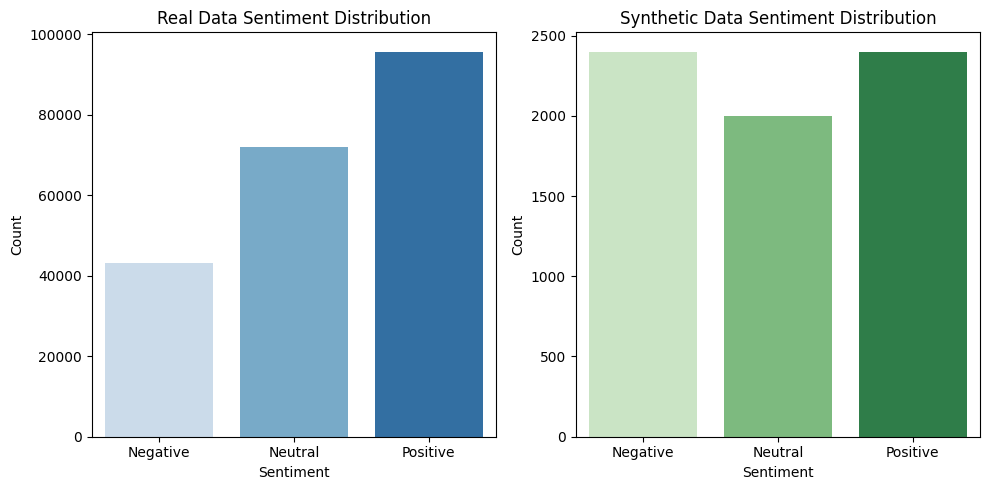

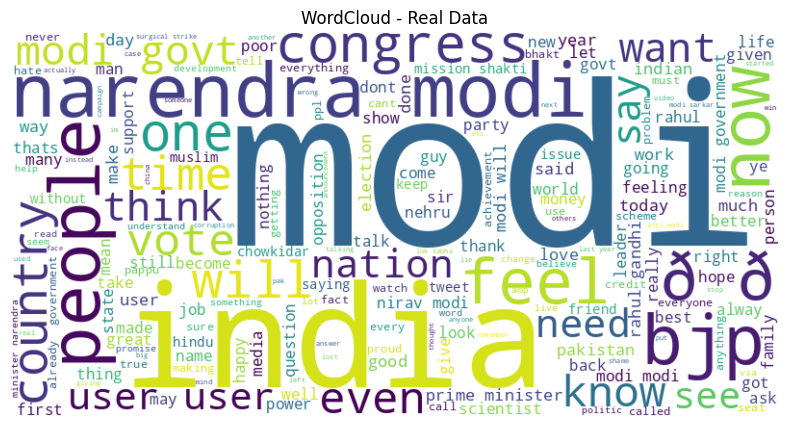

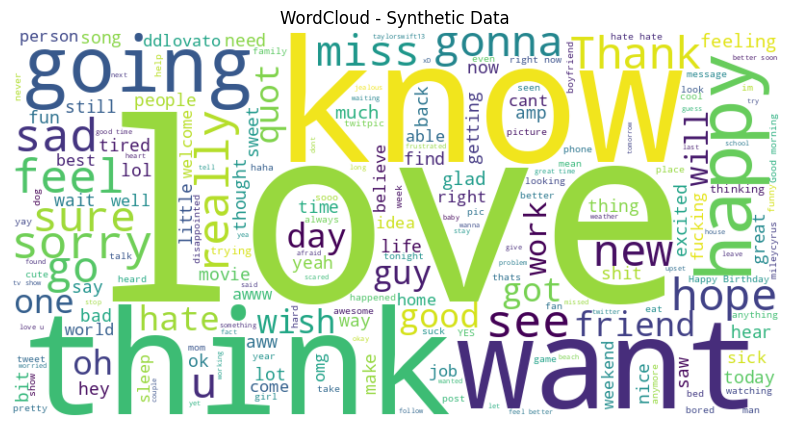

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# # 📂 Load real dataset
# real_df = pd.read_csv('your_real_dataset.csv')

# Compare distribution
plt.figure(figsize=(10, 5))

# Real
plt.subplot(1, 2, 1)
sns.countplot(x=df['sentiment_label_text'], palette="Blues")
plt.title("Real Data Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# Synthetic
plt.subplot(1, 2, 2)
sns.countplot(x=synthetic_df['overall_sentiment_label'], palette="Greens")
plt.title("Synthetic Data Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# 📊 Optional: Word Cloud
from wordcloud import WordCloud

real_text = " ".join(df['text'].dropna())
synthetic_text = " ".join(synthetic_df['text'].dropna())

# Real Data WordCloud
wordcloud_real = WordCloud(width=800, height=400, background_color="white").generate(real_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('WordCloud - Real Data')
plt.axis('off')
plt.show()

# Synthetic Data WordCloud
wordcloud_synth = WordCloud(width=800, height=400, background_color="white").generate(synthetic_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_synth, interpolation='bilinear')
plt.title('WordCloud - Synthetic Data')
plt.axis('off')
plt.show()


In [ ]:
!pip install -q umap-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import umap

# 🧠 Load a sentence transformer model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# ✨ Create embeddings
print("🔵 Embedding Real Data...")
real_embeddings = embedder.encode(df['text'].dropna().tolist(), show_progress_bar=True)

print("🔴 Embedding Synthetic Data...")
synthetic_embeddings = embedder.encode(synthetic_df['text'].dropna().tolist(), show_progress_bar=True)

# 📊 Combine embeddings for UMAP
all_embeddings = np.vstack((real_embeddings, synthetic_embeddings))

# 📉 Apply UMAP
print("\n⚡ Running UMAP...")
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
all_2d = umap_model.fit_transform(all_embeddings)

# 🔖 Prepare labels
labels = ['Real'] * len(real_embeddings) + ['Synthetic'] * len(synthetic_embeddings)

# 📍 Split back into real and synthetic
real_2d = all_2d[:len(real_embeddings)]
synthetic_2d = all_2d[len(real_embeddings):]

# 📈 Plotting
plt.figure(figsize=(12, 8))
plt.scatter(real_2d[:, 0], real_2d[:, 1], c='blue', alpha=0.5, label='Real Data', s=10)
plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], c='red', alpha=0.5, label='Synthetic Data', s=10)
plt.title('UMAP Visualization of Real vs Synthetic Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.grid(True)
plt.show()


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-1113e9f6fc5c>", line 7, in <cell line: 0>
    import umap
  File "/usr/local/lib/python3.11/dist-packages/umap/__init__.py", line 2, in <module>
    from .umap_ import UMAP
  File "/usr/local/lib/python3.11/dist-packages/umap/umap_.py", line 48, in <module>
    from pynndescent import NNDescent
  File "/usr/local/lib/python3.11/dist-packages/pynndescent/__init__.py", line 5, in <module>
    from .pynndescent_ import NNDescent, PyNNDescentTransformer
  File "/usr/local/lib/python3.11/dist-packages/pynndescent/pynndescent_.py", line 22, in <module>
    import pynndescent.sparse as sparse
  File "/usr/local/lib/python3.11/dist-packages/pynndescent/sparse.py", line 11, in <module>
    from pynndescent.distances import (
  File "/usr/local/lib/python3.11/dist-packages/pynnde

TypeError: object of type 'NoneType' has no len()

✅ 3. Train & Test Model (Real only / Fake only / Real+Fake)

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import pandas as pd
import torch
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fixed Sampling Function
def fixed_sample_per_class(df, label_col='overall_sentiment_label', samples_per_class=500):
    sampled_df = (
        df.groupby(label_col)
        .apply(lambda x: x.sample(min(len(x), samples_per_class), random_state=42))
        .reset_index(drop=True)
    )
    return sampled_df

# Encode Labels
def encode_labels(df, label_col):
    label2id = {label: i for i, label in enumerate(sorted(df[label_col].unique()))}
    id2label = {i: label for label, i in label2id.items()}
    df['label'] = df[label_col].map(label2id)
    return df, label2id, id2label

# Tokenize Function
def tokenize_function(example, tokenizer):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

# Train + Eval Function
def train_and_evaluate_transformer(df, model_name, text_col='text', label_col='overall_sentiment_label', description=""):
    df = df.dropna(subset=[text_col, label_col]).reset_index(drop=True)
    df, label2id, id2label = encode_labels(df, label_col)

    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df[text_col], df['label'], test_size=0.2, stratify=df['label'], random_state=42
    )

    train_df = Dataset.from_pandas(pd.DataFrame({text_col: train_texts, "label": train_labels}))
    test_df = Dataset.from_pandas(pd.DataFrame({text_col: test_texts, "label": test_labels}))

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label2id)).to(device)

    train_df = train_df.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    test_df = test_df.map(lambda x: tokenize_function(x, tokenizer), batched=True)

    train_df.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_df.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        logging_steps=100,
        no_cuda=not torch.cuda.is_available(),
        do_train=True,
        do_eval=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_df,
        eval_dataset=test_df,
    )

    trainer.train()

    predictions = trainer.predict(test_df)
    preds = np.argmax(predictions.predictions, axis=-1)

    acc = accuracy_score(test_labels, preds)
    print(f"\n🚀 Performance for {description} using {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(test_labels, preds, target_names=list(label2id.keys())))


In [ ]:
def sample_per_class(df, label_col, samples_per_class):
    return (
        df.groupby(label_col)
        .apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42))
        .reset_index(drop=True)
    )

# Rename label column for consistency
df = df.rename(columns={'sentiment_label_text': 'overall_sentiment_label'})

# Sample 1500 per class
real_sampled = sample_per_class(df, label_col='overall_sentiment_label', samples_per_class=1500)
synthetic_sampled = sample_per_class(synthetic_df, label_col='overall_sentiment_label', samples_per_class=1500)


<ipython-input-9-a359a94edf53>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42))
<ipython-input-9-a359a94edf53>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42))


In [ ]:
combined_dfs = []

for label in real_sampled['overall_sentiment_label'].unique():
    real_part = real_sampled[real_sampled['overall_sentiment_label'] == label].sample(n=750, random_state=42)
    synthetic_part = synthetic_sampled[synthetic_sampled['overall_sentiment_label'] == label].sample(n=750, random_state=42)
    combined_dfs.append(pd.concat([real_part, synthetic_part], ignore_index=True))

combined_sampled = pd.concat(combined_dfs, ignore_index=True)


In [ ]:
# Real Only
train_and_evaluate_transformer(real_sampled, model_name='bert-base-uncased', description='Real Only 1500/class')

# Synthetic Only
train_and_evaluate_transformer(synthetic_sampled, model_name='bert-base-uncased', description='Synthetic Only 1500/class')

# Combined 50/50
train_and_evaluate_transformer(combined_sampled, model_name='bert-base-uncased', description='Combined 750 Real + 750 Synthetic/class')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
10,1.127800
20,1.070700
30,1.095900
40,1.060200
50,1.085200
60,1.017400
70,0.981800
80,1.008400
90,0.872000
100,0.862600



🚀 Performance for Real Only 1500/class using bert-base-uncased:
Accuracy: 0.8233
              precision    recall  f1-score   support

    Negative       0.76      0.85      0.80       300
     Neutral       0.85      0.83      0.84       300
    Positive       0.87      0.79      0.83       300

    accuracy                           0.82       900
   macro avg       0.83      0.82      0.82       900
weighted avg       0.83      0.82      0.82       900



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
10,1.148500
20,1.114100
30,1.113400
40,1.103300
50,1.114700
60,1.092300
70,1.095900
80,1.087000
90,1.078000
100,1.088800



🚀 Performance for Synthetic Only 1500/class using bert-base-uncased:
Accuracy: 0.4289
              precision    recall  f1-score   support

    Negative       0.45      0.48      0.46       300
     Neutral       0.35      0.27      0.31       300
    Positive       0.46      0.54      0.50       300

    accuracy                           0.43       900
   macro avg       0.42      0.43      0.42       900
weighted avg       0.42      0.43      0.42       900



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
10,1.129400
20,1.117800
30,1.115100
40,1.138400
50,1.132700
60,1.118700
70,1.103300
80,1.099500
90,1.105800
100,1.106200



🚀 Performance for Combined 750 Real + 750 Synthetic/class using bert-base-uncased:
Accuracy: 0.5756
              precision    recall  f1-score   support

    Negative       0.61      0.50      0.55       300
     Neutral       0.53      0.59      0.55       300
    Positive       0.60      0.64      0.62       300

    accuracy                           0.58       900
   macro avg       0.58      0.58      0.57       900
weighted avg       0.58      0.58      0.57       900



In [ ]:
# List of models to evaluate
models = [
    # "bert-base-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "albert-base-v2",
    "xlnet-base-cased"
]

# Evaluate each model
for model_name in models:
    train_and_evaluate_transformer(real_sampled, model_name=model_name, description="Real Data Only (Fixed 500/class)")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: avantithale0922 (avantithale0922-sardar-vallabhbhai-national-institute-of) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,1.092900
200,1.038900
300,1.037600


Step,Training Loss
100,1.092900
200,1.038900
300,1.037600
400,0.966100
500,0.810700
600,0.741600
700,0.627200
800,0.585100
900,0.540800
1000,0.488000



🚀 Performance for Real Data Only (Fixed 500/class) using roberta-base:
Accuracy: 0.7867
              precision    recall  f1-score   support

    Negative       0.75      0.80      0.77       300
     Neutral       0.81      0.80      0.81       300
    Positive       0.80      0.76      0.78       300

    accuracy                           0.79       900
   macro avg       0.79      0.79      0.79       900
weighted avg       0.79      0.79      0.79       900



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,0.985000
200,0.678600
300,0.456200
400,0.357600
500,0.271800
600,0.211100
700,0.152000
800,0.110700
900,0.135600
1000,0.100300



🚀 Performance for Real Data Only (Fixed 500/class) using distilbert-base-uncased:
Accuracy: 0.8389
              precision    recall  f1-score   support

    Negative       0.78      0.87      0.82       300
     Neutral       0.91      0.83      0.87       300
    Positive       0.84      0.82      0.83       300

    accuracy                           0.84       900
   macro avg       0.84      0.84      0.84       900
weighted avg       0.84      0.84      0.84       900



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,1.111000
200,1.094500
300,1.094900
400,1.067700
500,0.965600
600,0.877800
700,0.725400
800,0.658300
900,0.651600
1000,0.531400



🚀 Performance for Real Data Only (Fixed 500/class) using albert-base-v2:
Accuracy: 0.7967
              precision    recall  f1-score   support

    Negative       0.78      0.77      0.78       300
     Neutral       0.81      0.85      0.83       300
    Positive       0.79      0.77      0.78       300

    accuracy                           0.80       900
   macro avg       0.80      0.80      0.80       900
weighted avg       0.80      0.80      0.80       900



config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,1.051800
200,0.868600
300,0.623100
400,0.531300
500,0.409300
600,0.330800
700,0.223200
800,0.197600
900,0.177600
1000,0.146500


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]


🚀 Performance for Real Data Only (Fixed 500/class) using xlnet-base-cased:
Accuracy: 0.8144
              precision    recall  f1-score   support

    Negative       0.75      0.85      0.80       300
     Neutral       0.88      0.79      0.83       300
    Positive       0.82      0.80      0.81       300

    accuracy                           0.81       900
   macro avg       0.82      0.81      0.82       900
weighted avg       0.82      0.81      0.82       900



In [ ]:
 # List of models to evaluate1
models = [
    # "bert-base-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "albert-base-v2",
    "xlnet-base-cased"
]

# Evaluate each model
for model_name in models:
    train_and_evaluate_transformer(synthetic_sampled, model_name=model_name, description="Synthetic Data Only (Fixed 500/class)")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,1.107900
200,1.090900
300,1.103100
400,1.101300
500,1.104600
600,1.103600
700,1.102100
800,1.102900
900,1.099000
1000,1.100100



🚀 Performance for Synthetic Data Only (Fixed 500/class) using roberta-base:
Accuracy: 0.3700
              precision    recall  f1-score   support

    Negative       0.48      0.04      0.07       300
     Neutral       0.37      0.13      0.19       300
    Positive       0.37      0.94      0.53       300

    accuracy                           0.37       900
   macro avg       0.41      0.37      0.26       900
weighted avg       0.41      0.37      0.26       900



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,1.080500
200,1.050200
300,0.998000
400,1.008300
500,0.926500
600,0.842500
700,0.782500
800,0.637000
900,0.658200
1000,0.452800



🚀 Performance for Synthetic Data Only (Fixed 500/class) using distilbert-base-uncased:
Accuracy: 0.4144
              precision    recall  f1-score   support

    Negative       0.47      0.42      0.44       300
     Neutral       0.34      0.41      0.37       300
    Positive       0.46      0.42      0.44       300

    accuracy                           0.41       900
   macro avg       0.42      0.41      0.42       900
weighted avg       0.42      0.41      0.42       900



Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,1.127700
200,1.113400
300,1.110300
400,1.110400


Step,Training Loss
100,1.127700
200,1.113400
300,1.110300
400,1.110400
500,1.096600
600,1.101400
700,1.097400
800,1.085500
900,1.079100
1000,1.050400



🚀 Performance for Synthetic Data Only (Fixed 500/class) using albert-base-v2:
Accuracy: 0.4011
              precision    recall  f1-score   support

    Negative       0.39      0.68      0.50       300
     Neutral       0.15      0.01      0.01       300
    Positive       0.42      0.52      0.47       300

    accuracy                           0.40       900
   macro avg       0.32      0.40      0.33       900
weighted avg       0.32      0.40      0.33       900



Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,1.126300
200,1.112900
300,1.088000
400,1.079600
500,1.020000
600,1.015400
700,0.981900
800,0.909400
900,0.935400
1000,0.758900



🚀 Performance for Synthetic Data Only (Fixed 500/class) using xlnet-base-cased:
Accuracy: 0.4156
              precision    recall  f1-score   support

    Negative       0.43      0.45      0.44       300
     Neutral       0.34      0.26      0.30       300
    Positive       0.45      0.54      0.49       300

    accuracy                           0.42       900
   macro avg       0.41      0.42      0.41       900
weighted avg       0.41      0.42      0.41       900



In [ ]:
 # List of models to evaluate
models = [
    # "bert-base-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "albert-base-v2",
    "xlnet-base-cased"
]

# Evaluate each model
for model_name in models:
    train_and_evaluate_transformer(combined_sampled, model_name=model_name, description="Combined Data Only")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,1.107000
200,1.099600
300,1.090800
400,1.092700
500,1.111600
600,1.103900
700,1.101200
800,1.103900
900,1.099100
1000,1.100100



🚀 Performance for Combined Data Only using roberta-base:
Accuracy: 0.3333
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       300
     Neutral       0.00      0.00      0.00       300
    Positive       0.33      1.00      0.50       300

    accuracy                           0.33       900
   macro avg       0.11      0.33      0.17       900
weighted avg       0.11      0.33      0.17       900



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of DistilBertForSequenceClassificati

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,1.074500
200,0.985900
300,0.832900
400,0.750000
500,0.642600
600,0.543500
700,0.468700
800,0.345800
900,0.331300
1000,0.211200



🚀 Performance for Combined Data Only using distilbert-base-uncased:
Accuracy: 0.5611
              precision    recall  f1-score   support

    Negative       0.60      0.54      0.57       300
     Neutral       0.51      0.52      0.51       300
    Positive       0.58      0.62      0.60       300

    accuracy                           0.56       900
   macro avg       0.56      0.56      0.56       900
weighted avg       0.56      0.56      0.56       900



Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,1.112700
200,1.108500
300,1.117900
400,1.106500
500,1.122700
600,1.115200
700,1.106900
800,1.110200
900,1.102000
1000,1.094300



🚀 Performance for Combined Data Only using albert-base-v2:
Accuracy: 0.3989
              precision    recall  f1-score   support

    Negative       0.41      0.52      0.46       300
     Neutral       0.39      0.61      0.48       300
    Positive       0.37      0.06      0.11       300

    accuracy                           0.40       900
   macro avg       0.39      0.40      0.35       900
weighted avg       0.39      0.40      0.35       900



Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Step,Training Loss
100,1.113700
200,1.096100
300,1.001800
400,0.926900
500,0.809900
600,0.749700
700,0.670900
800,0.527800
900,0.537200
1000,0.355300



🚀 Performance for Combined Data Only using xlnet-base-cased:
Accuracy: 0.5767
              precision    recall  f1-score   support

    Negative       0.58      0.59      0.58       300
     Neutral       0.57      0.48      0.52       300
    Positive       0.58      0.66      0.62       300

    accuracy                           0.58       900
   macro avg       0.58      0.58      0.57       900
weighted avg       0.58      0.58      0.57       900



#EDA and Visualization on generate data

In [ ]:
synthetic_df.head()

,text,overall_sentiment_label,fine_grained_label
0,wishing you would leave me alone.,Negative,joyful
1,ughhhh. u r sad.,Negative,joyful
2,i miss my old laptop i have been using for 4 y...,Negative,joyful
3,A happy birthday. Hope you have a great day!,Negative,joyful
4,@roosemary You've got my number!,Negative,joyful


In [ ]:
synthetic_df.shape

(6800, 3)

In [ ]:
synthetic_df.describe()

,text,overall_sentiment_label,fine_grained_label
count,6800,6800,6800
unique,6687,3,12
top,i love you,Negative,joyful
freq,25,2400,600


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download("vader_lexicon")
sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
def show_top_tfidf_words_per_class(df, text_col='text', label_col='overall_sentiment_label', top_n=10):
    labels = df[label_col].unique()
    for label in labels:
        class_texts = df[df[label_col] == label][text_col].dropna().astype(str)
        vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
        tfidf_matrix = vectorizer.fit_transform(class_texts)
        mean_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
        top_indices = mean_tfidf.argsort()[::-1][:top_n]
        top_terms = [vectorizer.get_feature_names_out()[i] for i in top_indices]
        top_scores = mean_tfidf[top_indices]

        print(f"\n🔠 Top TF-IDF terms for class: {label}")
        for word, score in zip(top_terms, top_scores):
            print(f"{word}: {score:.4f}")


In [ ]:
def sentiment_score_heatmap(df, text_col='text', label_col='overall_sentiment_label'):
    # Calculate sentiment scores
    df = df.copy()
    df[['neg', 'neu', 'pos', 'compound']] = df[text_col].apply(
        lambda x: pd.Series(sid.polarity_scores(str(x)))
    )

    # Group by class and compute average sentiment scores
    sentiment_avg = df.groupby(label_col)[['neg', 'neu', 'pos', 'compound']].mean()

    # Heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(sentiment_avg, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Average VADER Sentiment Scores per Class")
    plt.xlabel("Sentiment Score Type")
    plt.ylabel("Class Label")
    plt.tight_layout()
    plt.show()



🔠 Top TF-IDF terms for class: Negative
know: 0.0258
hate: 0.0241
just: 0.0237
love: 0.0219
sad: 0.0216
think: 0.0209
miss: 0.0199
want: 0.0192
like: 0.0188
don: 0.0180

🔠 Top TF-IDF terms for class: Neutral
love: 0.0401
know: 0.0259
just: 0.0235
think: 0.0189
like: 0.0185
happy: 0.0184
want: 0.0169
sorry: 0.0157
good: 0.0147
feel: 0.0137

🔠 Top TF-IDF terms for class: Positive
love: 0.0621
happy: 0.0274
good: 0.0229
know: 0.0223
just: 0.0222
like: 0.0167
think: 0.0157
thanks: 0.0149
day: 0.0139
new: 0.0130


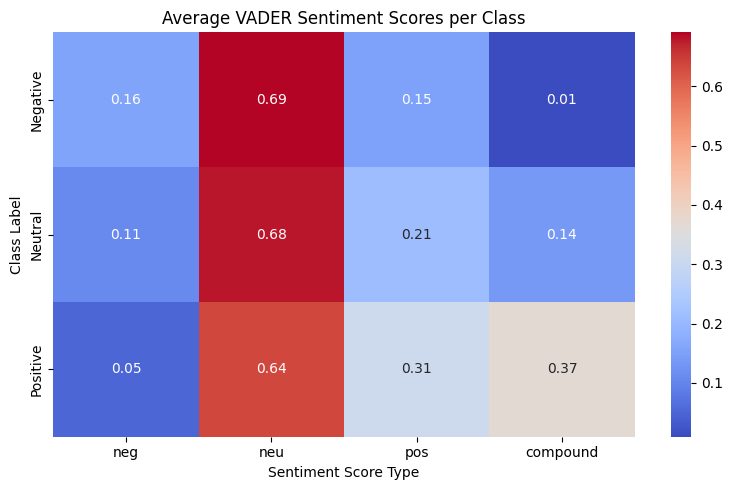

In [ ]:
# Example usage:
show_top_tfidf_words_per_class(synthetic_df, text_col='text', label_col='overall_sentiment_label')
sentiment_score_heatmap(synthetic_df, text_col='text', label_col='overall_sentiment_label')


In [ ]:
print("\n🔖 Fine-grained classes in Real Data:")
print(df['fine_grained_label'].unique())
print("\n📊 Fine-grained class distribution:")
print(df['fine_grained_label'].value_counts())


print("\n🔖 Overall classes in Real Data:")
print(df['overall_sentiment_label'].unique())
print("\n📊 Overall class distribution:")
print(df['overall_sentiment_label'].value_counts())


🔖 Fine-grained classes in Real Data:
['joyful' 'melancholy' 'frustrated' 'anxious' 'affectionate' 'curious'
 'despairing hate' 'sarcastic mockery' 'aggressive hate' 'toxic love'
 'fear-driven hate' 'mocking disbelief']

📊 Fine-grained class distribution:
fine_grained_label
joyful               150449
melancholy            46240
frustrated             4952
anxious                3719
affectionate           2154
sarcastic mockery      1807
curious                 969
despairing hate         529
aggressive hate          90
toxic love               11
fear-driven hate          9
mocking disbelief         9
Name: count, dtype: int64

🔖 Overall classes in Real Data:
['Negative' 'Neutral' 'Positive' nan]

📊 Overall class distribution:
overall_sentiment_label
Positive    95707
Neutral     71978
Negative    43246
Name: count, dtype: int64


In [ ]:
print("\n🔖 Fine-grained classes in synthetic data:")
print(synthetic_df['fine_grained_label'].unique())
print("\n📊 Fine-grained class distribution:")
print(synthetic_df['fine_grained_label'].value_counts())

print("\n🔖 Overall classes in Real Data:")
print(synthetic_df['overall_sentiment_label'].unique())
print("\n📊 Overall class distribution:")
print(synthetic_df['overall_sentiment_label'].value_counts())


🔖 Fine-grained classes in synthetic data:
['joyful' 'melancholy' 'frustrated' 'anxious' 'affectionate' 'curious'
 'despairing hate' 'sarcastic mockery' 'aggressive hate' 'toxic love'
 'fear-driven hate' 'mocking disbelief']

📊 Fine-grained class distribution:
fine_grained_label
joyful               600
melancholy           600
frustrated           600
anxious              600
affectionate         600
curious              600
despairing hate      600
sarcastic mockery    600
aggressive hate      600
fear-driven hate     600
toxic love           400
mocking disbelief    400
Name: count, dtype: int64

🔖 Overall classes in Real Data:
['Negative' 'Neutral' 'Positive']

📊 Overall class distribution:
overall_sentiment_label
Negative    2400
Positive    2400
Neutral     2000
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Define top-N fine-grained classes
selected_classes = [
    "joyful", "melancholy", "frustrated",
    "anxious", "affectionate", "sarcastic mockery", "curious"
]

# Function to filter and sample data
def filter_and_sample(df, label_col='fine_grained_label', sample_size=1500):
    df_filtered = df[df[label_col].isin(selected_classes)]
    df_sampled = (
        df_filtered.groupby(label_col, group_keys=False)
        .apply(lambda x: x.sample(n=sample_size, random_state=42))
        .reset_index(drop=True)
    )
    return df_sampled

# Apply to real and synthetic datasets
fine_real_sampled = filter_and_sample(df, label_col="fine_grained_label", sample_size=600)
fine_synthetic_sampled = filter_and_sample(synthetic_df, label_col="fine_grained_label", sample_size=600)

# Create combined dataset (50/50 real + synthetic)
fine_combined_sampled = pd.concat([
    fine_real_sampled,
    fine_synthetic_sampled
]).reset_index(drop=True)

# Optionally shuffle the combined data
fine_combined_sampled = fine_combined_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Real sampled shape:", fine_real_sampled.shape)
print("✅ Synthetic sampled shape:", fine_synthetic_sampled.shape)
print("✅ Combined shape:", fine_combined_sampled.shape)
print("\n📊 Combined class distribution:\n", fine_combined_sampled["fine_grained_label"].value_counts())


✅ Real sampled shape: (4200, 10)
✅ Synthetic sampled shape: (4200, 3)
✅ Combined shape: (8400, 10)

📊 Combined class distribution:
 fine_grained_label
affectionate         1200
anxious              1200
melancholy           1200
curious              1200
sarcastic mockery    1200
joyful               1200
frustrated           1200
Name: count, dtype: int64


<ipython-input-38-541540bb4ea0>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=sample_size, random_state=42))
<ipython-input-38-541540bb4ea0>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=sample_size, random_state=42))


In [ ]:
test_df["true_label"] = y_true
test_df["predicted_label"] = y_preds
misclassified = test_df[test_df["true_label"] != test_df["predicted_label"]]
print(misclassified.sample(10))


                                                   text  sentiment_label  \
750       i wish i could be as big a fucking dog as you              NaN   
851   i'm getting so sick of the u.s. and the tv sho...              NaN   
524   say hes deeply divisive understatement modis c...             -1.0   
4328     @NeilJNWW aw ok i'm so glad you got a new guy!              NaN   
4176                        @BrianneMcIntyre Thank you!              NaN   
2445  @scyteemkohl you better be getting off this sh...              NaN   
2214  dear sir this from constituency almoradhaulade...              0.0   
130   modi and bhaidude your gonna antagonise two mo...             -1.0   
3730  transfered the womb bhushan late 50s october 1...              1.0   
828   I'm so glad i didn't start my own vlog for twi...              NaN   

      emotion_label  hate_speech_label     source_dataset fine_grained_label  \
750             NaN                NaN                NaN  sarcastic mockery   
851

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Encode labels
labels = sorted(combined_sampled["fine_grained_label"].unique())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}
combined_sampled["label"] = combined_sampled["fine_grained_label"].map(label2id)

# Train-test split
train_df = combined_sampled.sample(frac=0.8, random_state=42)
test_df = combined_sampled.drop(train_df.index)

# Tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = Dataset.from_pandas(train_df[["text", "label"]]).map(tokenize)
test_dataset = Dataset.from_pandas(test_df[["text", "label"]]).map(tokenize)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# Training arguments (compatible with older versions)
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    logging_dir="./logs"
)

# Metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "macro_f1": classification_report(p.label_ids, preds, output_dict=True, zero_division=0)["macro avg"]["f1-score"]
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 🚀 Start training
trainer.train()

# 🧪 Evaluate
preds_output = trainer.predict(test_dataset)
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

print("\n📊 Classification Report:")
print(classification_report(y_true, y_preds, target_names=labels, zero_division=0))


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.644200



📊 Classification Report:
                   precision    recall  f1-score   support

     affectionate       0.23      0.29      0.26        41
  aggressive hate       0.00      0.00      0.00        39
          anxious       0.41      0.13      0.20        54
          curious       0.19      0.33      0.24        48
  despairing hate       0.12      0.07      0.09        44
 fear-driven hate       0.24      0.10      0.14        40
       frustrated       0.19      0.28      0.22        46
           joyful       0.77      0.74      0.75       359
       melancholy       0.42      0.46      0.44       153
mocking disbelief       0.00      0.00      0.00        19
sarcastic mockery       0.10      0.24      0.14        33
       toxic love       0.38      0.42      0.40        24

         accuracy                           0.46       900
        macro avg       0.25      0.26      0.24       900
     weighted avg       0.46      0.46      0.45       900



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Encode labels
labels = sorted(combined_sampled["fine_grained_label"].unique())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}
combined_sampled["label"] = combined_sampled["fine_grained_label"].map(label2id)

# Train-test split
train_df = combined_sampled.sample(frac=0.8, random_state=42)
test_df = combined_sampled.drop(train_df.index)

# Tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = Dataset.from_pandas(train_df[["text", "label"]]).map(tokenize)
test_dataset = Dataset.from_pandas(test_df[["text", "label"]]).map(tokenize)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# Training arguments (compatible with older versions)
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    logging_dir="./logs"
)

# Metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "macro_f1": classification_report(p.label_ids, preds, output_dict=True, zero_division=0)["macro avg"]["f1-score"]
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 🚀 Start training
trainer.train()

# 🧪 Evaluate
preds_output = trainer.predict(test_dataset)
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

print("\n📊 Classification Report:")
print(classification_report(y_true, y_preds, target_names=labels, zero_division=0))


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.676600



📊 Classification Report:
                   precision    recall  f1-score   support

     affectionate       0.26      0.41      0.32        41
  aggressive hate       0.25      0.13      0.17        39
          anxious       0.37      0.26      0.30        54
          curious       0.23      0.33      0.27        48
  despairing hate       0.15      0.14      0.14        44
 fear-driven hate       0.00      0.00      0.00        40
       frustrated       0.40      0.39      0.40        46
           joyful       0.70      0.87      0.77       359
       melancholy       0.37      0.22      0.27       153
mocking disbelief       0.00      0.00      0.00        19
sarcastic mockery       0.12      0.27      0.16        33
       toxic love       0.50      0.04      0.08        24

         accuracy                           0.48       900
        macro avg       0.28      0.25      0.24       900
     weighted avg       0.44      0.48      0.44       900



# generation with sampled data

In [ ]:
# SECTION 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Optional: For XLNet validation
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
# Replace with your actual file path
df = pd.read_csv("/content/drive/MyDrive/Mini Project/Generated/sampled.csv")
df.head()


,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,final_sentiment,final_sentiment_label,validation_flags,final_validation_flags,fine_grained_validation_flags,ensemble_sentiment,overall_sentiment,sentiment_str,predicted_fine_grained
0,india joins the elite club congratulations all...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy
1,this pure bravery only firing bullets and ches...,1.0,0.0,0.0,sentiment_dataset,melancholy,Positive,Positive,1,1,1,Positive,Mismatch: Sentiment should be 'negative' for f...,Mismatch: Sentiment should be 'negative' for f...,Mismatch: Fine-grained label 'melancholy' shou...,1,1,positive,surprise
2,you are true you have guts then the video wher...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,surprise
3,when modi was destroying economy with demoneti...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Fine-grained label 'joyful' should h...,-1,-1,negative,surprise
4,excellent,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy


In [ ]:
df.columns

Index(['text', 'sentiment_label', 'emotion_label', 'hate_speech_label',
       'source_dataset', 'fine_grained_label', 'sentiment_label_text',
       'predicted_sentiment_label', 'bert_predicted_sentiment_label',
       'predicted_sentiment_label_numeric', 'final_sentiment',
       'final_sentiment_label', 'validation_flags', 'final_validation_flags',
       'fine_grained_validation_flags', 'ensemble_sentiment',
       'overall_sentiment', 'sentiment_str', 'predicted_fine_grained'],
      dtype='object')

text                                     0
sentiment_label                          0
emotion_label                            0
hate_speech_label                        0
source_dataset                           0
fine_grained_label                       0
sentiment_label_text                     0
predicted_sentiment_label                0
bert_predicted_sentiment_label           0
predicted_sentiment_label_numeric        0
final_sentiment                          0
final_sentiment_label                    0
validation_flags                     11554
final_validation_flags               13971
fine_grained_validation_flags         3031
ensemble_sentiment                       0
overall_sentiment                        0
sentiment_str                            0
predicted_fine_grained                   0
dtype: int64


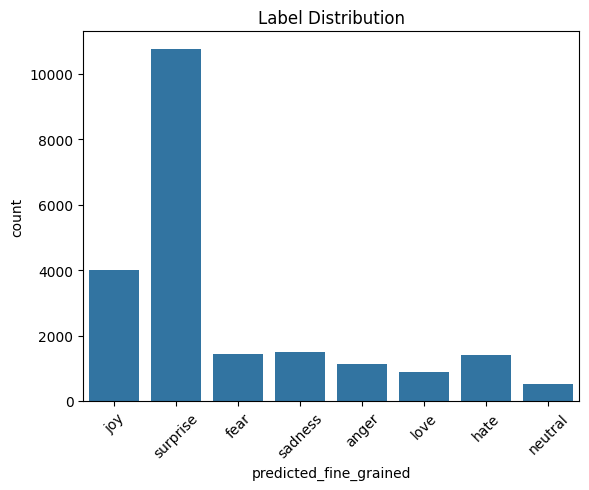

In [ ]:
# Check nulls
print(df.isnull().sum())

# Label distribution
fine_grained = "predicted_fine_grained"  # change if named differently
sns.countplot(data=df, x=fine_grained)
plt.title("Label Distribution")
plt.xticks(rotation=45)
plt.show()


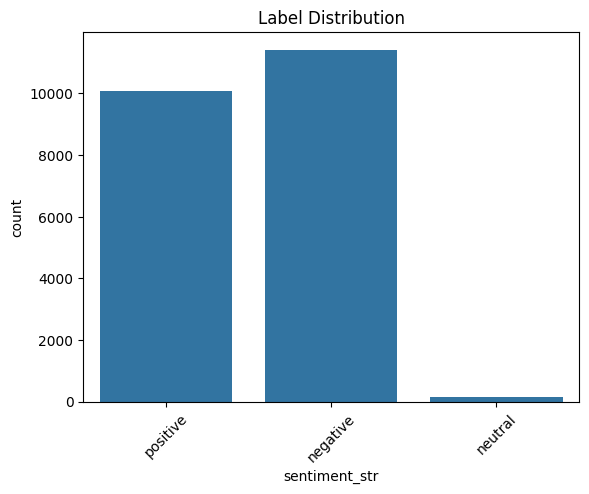

In [ ]:

# Label distribution
overall = "sentiment_str"  # change if named differently
sns.countplot(data=df, x=overall)
plt.title("Label Distribution")
plt.xticks(rotation=45)
plt.show()


        text_length    word_count
count  21644.000000  21644.000000
mean     119.620634     19.629366
std       64.360591     10.484966
min        4.000000      1.000000
25%       68.000000     11.000000
50%      107.000000     18.000000
75%      169.000000     28.000000
max      297.000000     64.000000


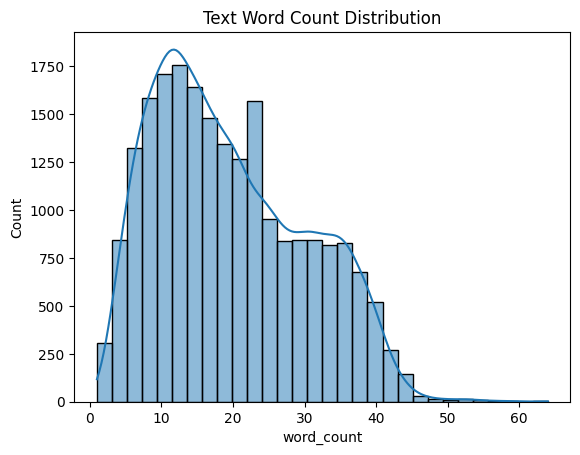

In [ ]:
df["text_length"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().str.len()

print(df[["text_length", "word_count"]].describe())

sns.histplot(df["word_count"], bins=30, kde=True)
plt.title("Text Word Count Distribution")
plt.show()


#generation

In [ ]:
sentiment_mapping = {
    "neutral": ["neutral"],
    "positive": ["joy", "love", "surprise"],
    "negative": ["sadness", "anger", "fear", "hate"]
}

In [ ]:
from transformers import pipeline
import random

In [ ]:
# Load FLAN-T5 model for text generation
synthetic_data = []
batch_size = 8  # You can increase based on GPU capacity

for overall in sentiment_mapping:
    fine_options = sentiment_mapping[overall]
    prompts = []

    # Generate all prompts first
    for _ in range(700):
        fine = random.choice(fine_options)
        prompt = f"Generate a social media post/tweet that expresses {fine} emotion with an overall {overall} sentiment."
        prompts.append((prompt, overall, fine))

    # Process in batches
    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i+batch_size]
        batch_prompts = [p[0] for p in batch]

        responses = generator(batch_prompts, max_length=140, min_length=100, do_sample=True, top_k=50)

        for j, output in enumerate(responses):
            synthetic_data.append({
                "text": output['generated_text'],
                "overall_sentiment": batch[j][1],
                "fine_grained_sentiment": batch[j][2]
            })

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

In [ ]:
synthetic_df.to_csv('/content/drive/MyDrive/Mini Project/Generated/synthetic_dataset_from_stratified_sampled.csv', index=False)


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Encode labels
le_overall = LabelEncoder()
synthetic_df["overall_label"] = le_overall.fit_transform(synthetic_df["overall_sentiment"])

# Tokenizer & model
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

xlnet_dataset = Dataset.from_pandas(synthetic_df[["text", "overall_label"]].rename(columns={"overall_label": "labels"}))
xlnet_dataset = xlnet_dataset.map(tokenize, batched=True)

# Dummy train/eval split (since it's synthetic, use 80/20 split)
xlnet_dataset = xlnet_dataset.train_test_split(test_size=0.2)

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=len(le_overall.classes_))

training_args = TrainingArguments(
    output_dir="./xlnet_validation",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=10
)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=xlnet_dataset["train"],
    eval_dataset=xlnet_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
eval_results = trainer.evaluate()

print("\nXLNet Validation Results on Synthetic Data:")
print(eval_results)


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-7cb357a6aa3a>:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: avantithale0922 (avantithale0922-sardar-vallabhbhai-national-institute-of) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.242200
20,1.163200
30,1.114000
40,1.066000
50,1.080600
60,1.016000
70,1.157900
80,1.067100
90,0.984000
100,0.847300



XLNet Validation Results on Synthetic Data:
{'eval_loss': 0.8225599527359009, 'eval_accuracy': 0.6285714285714286, 'eval_precision': 0.637030716673518, 'eval_recall': 0.6285714285714286, 'eval_f1': 0.6277273964651126, 'eval_runtime': 66.9925, 'eval_samples_per_second': 6.269, 'eval_steps_per_second': 0.791, 'epoch': 1.0}


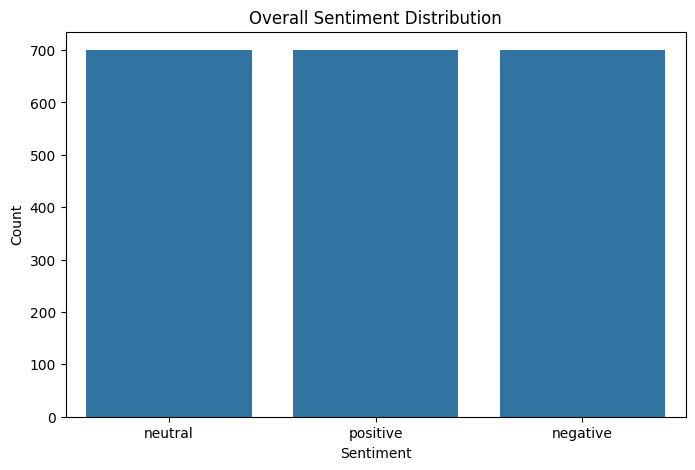

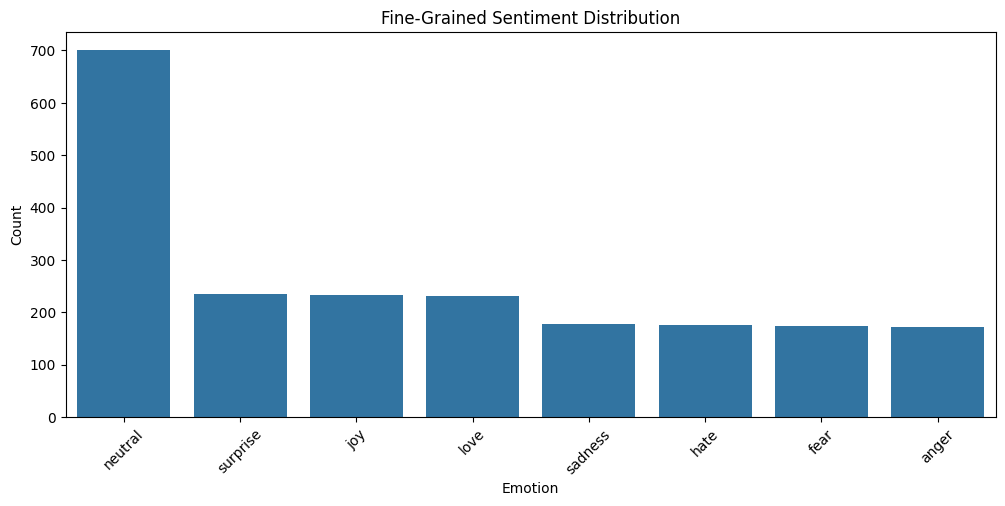

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot overall sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=synthetic_df, x='overall_sentiment', order=synthetic_df['overall_sentiment'].value_counts().index)
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Plot fine-grained sentiment distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=synthetic_df, x='fine_grained_sentiment', order=synthetic_df['fine_grained_sentiment'].value_counts().index)
plt.title("Fine-Grained Sentiment Distribution")
plt.xticks(rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()


In [ ]:
# Display a few random samples
print("\nSample Synthetic Posts:")
display(synthetic_df.sample(5)[["text", "overall_sentiment", "fine_grained_sentiment"]])



Sample Synthetic Posts:


,text,overall_sentiment,fine_grained_sentiment
1034,i love her!! i haven't seen either episode and...,positive,joy
1176,"@jasherd I am enjoying a nice nice, long day, ...",positive,love
67,"@CrazyRunt, Yeah me too.. I love the way you g...",neutral,neutral
1330,Its just not long until we see the beautiful w...,positive,joy
650,@CheltenhamPhoebe Have Fun On Your Trip!!! Gla...,neutral,neutral


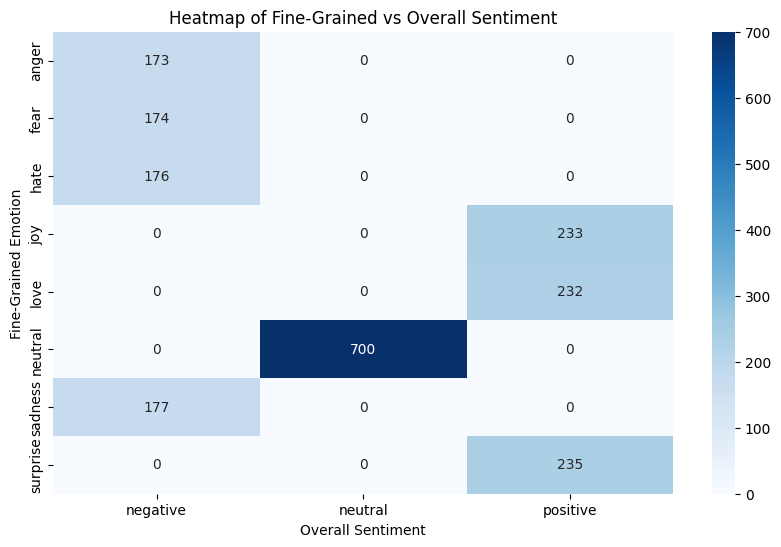

In [ ]:
cross_tab = pd.crosstab(synthetic_df['fine_grained_sentiment'], synthetic_df['overall_sentiment'])

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="Blues")
plt.title("Heatmap of Fine-Grained vs Overall Sentiment")
plt.xlabel("Overall Sentiment")
plt.ylabel("Fine-Grained Emotion")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    synthetic_df['text'], synthetic_df['overall_sentiment'], test_size=0.2, random_state=42
)

# Vectorization
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_vec)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred))


Logistic Regression Results:
              precision    recall  f1-score   support

    negative       0.64      0.65      0.64       137
     neutral       0.46      0.36      0.40       152
    positive       0.53      0.66      0.59       131

    accuracy                           0.55       420
   macro avg       0.54      0.56      0.55       420
weighted avg       0.54      0.55      0.54       420



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    synthetic_df['text'], synthetic_df['fine_grained_sentiment'], test_size=0.2, random_state=42
)

# Vectorization
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_vec)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred))


Logistic Regression Results:
              precision    recall  f1-score   support

       anger       1.00      0.03      0.06        30
        fear       0.00      0.00      0.00        38
        hate       0.50      0.03      0.05        38
         joy       0.11      0.02      0.04        47
        love       0.35      0.20      0.25        45
     neutral       0.38      0.89      0.53       152
     sadness       0.75      0.29      0.42        31
    surprise       0.10      0.03      0.04        39

    accuracy                           0.38       420
   macro avg       0.40      0.19      0.17       420
weighted avg       0.37      0.38      0.27       420



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Label encode
le = LabelEncoder()
synthetic_df["label"] = le.fit_transform(synthetic_df["overall_sentiment"])

# Prepare dataset
dataset = Dataset.from_pandas(synthetic_df[["text", "label"]])

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.train_test_split(test_size=0.2)

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(le.classes_))

# Training setup
training_args = TrainingArguments(
    output_dir="./bert_synthetic_sentiment",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=10,
    eval_steps=500,  # You can tune this based on dataset size
    report_to="none"
)


def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': (preds == pred.label_ids).mean()
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
eval_results = trainer.evaluate()

print("BERT Evaluation on Synthetic Data:")
print(eval_results)


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-f84f0697f792>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.160600
20,1.129800
30,1.099400
40,1.050100
50,1.081200
60,0.936200
70,0.995100
80,1.001600
90,0.913400
100,0.875400


BERT Evaluation on Synthetic Data:
{'eval_loss': 0.8802898526191711, 'eval_accuracy': 0.6190476190476191, 'eval_runtime': 11.8507, 'eval_samples_per_second': 35.441, 'eval_steps_per_second': 4.472, 'epoch': 2.0}


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Label encode
le = LabelEncoder()
synthetic_df["label"] = le.fit_transform(synthetic_df["fine_grained_sentiment"])

# Prepare dataset
dataset = Dataset.from_pandas(synthetic_df[["text", "label"]])

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.train_test_split(test_size=0.2)

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(le.classes_))

# Training setup
training_args = TrainingArguments(
    output_dir="./bert_synthetic_sentiment",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=10,
    eval_steps=500,  # You can tune this based on dataset size
    report_to="none"
)


def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': (preds == pred.label_ids).mean()
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
eval_results = trainer.evaluate()

print("BERT Evaluation on Synthetic Data:")
print(eval_results)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(synthetic_df['text'])
y = synthetic_df['fine_grained_sentiment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, lr_preds))

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("SVM:\n", classification_report(y_test, svm_preds))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, rf_preds))


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(synthetic_df['text'])
y = synthetic_df['overall_sentiment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, lr_preds))

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
print("SVM:\n", classification_report(y_test, svm_preds))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, rf_preds))


In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np

# Prepare Dataset
dataset = Dataset.from_pandas(synthetic_df[["text", "overall_sentiment"]])

# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.train_test_split(test_size=0.2)

# Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(le.classes_))

# Training Arguments (no evaluation_strategy for compatibility)
training_args = TrainingArguments(
    output_dir="./distilbert_synthetic_sentiment",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    eval_steps=500
)

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': (preds == pred.label_ids).mean()
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train & Evaluate
trainer.train()
eval_results = trainer.evaluate()
print("DistilBERT Evaluation on Synthetic Data:")
print(eval_results)


In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np

# Prepare Dataset
dataset = Dataset.from_pandas(synthetic_df[["text", "fine_grained_sentiment"]])

# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.train_test_split(test_size=0.2)

# Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(le.classes_))

# Training Arguments (no evaluation_strategy for compatibility)
training_args = TrainingArguments(
    output_dir="./distilbert_synthetic_sentiment",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    eval_steps=500
)

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': (preds == pred.label_ids).mean()
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train & Evaluate
trainer.train()
eval_results = trainer.evaluate()
print("DistilBERT Evaluation on Synthetic Data:")
print(eval_results)
